In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
from matplotlib.patches import Rectangle

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Download and load the LFW dataset
lfw_dataset = datasets.LFWPeople(root='./data', download=True, transform=data_transforms)

# Extract labels from the dataset (each image has a corresponding person label)
labels = [label for _, label in lfw_dataset]

# Organize data by person ID: {person_id: list of image indices}
person_to_indices = {}
for idx, label in enumerate(labels):
    if label not in person_to_indices:
        person_to_indices[label] = []
    person_to_indices[label].append(idx)

# Split each person's images into train/val sets, ensuring that all people appear in both train and val
train_indices = []
val_indices = []
for person, indices in person_to_indices.items():
    if len(indices) > 1:
        # If a person has more than one image, split them between training and validation
        train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
        train_indices.extend(train_idx)
        val_indices.extend(val_idx)
    else:
        # If a person has only one image, put it all in the training set
        train_indices.extend(indices)

# Create Subsets for training and validation using the indices
train_dataset = torch.utils.data.Subset(lfw_dataset, train_indices)
val_dataset = torch.utils.data.Subset(lfw_dataset, val_indices)

# Create DataLoader objects for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

100%|██████████| 243346528/243346528 [04:00<00:00, 1012863.36it/s]


Extracting ./data/lfw-py/lfw-funneled.tgz to ./data/lfw-py


100%|██████████| 94770/94770 [00:00<00:00, 346562.05it/s]


100%|██████████| 94727/94727 [00:00<00:00, 360437.48it/s]


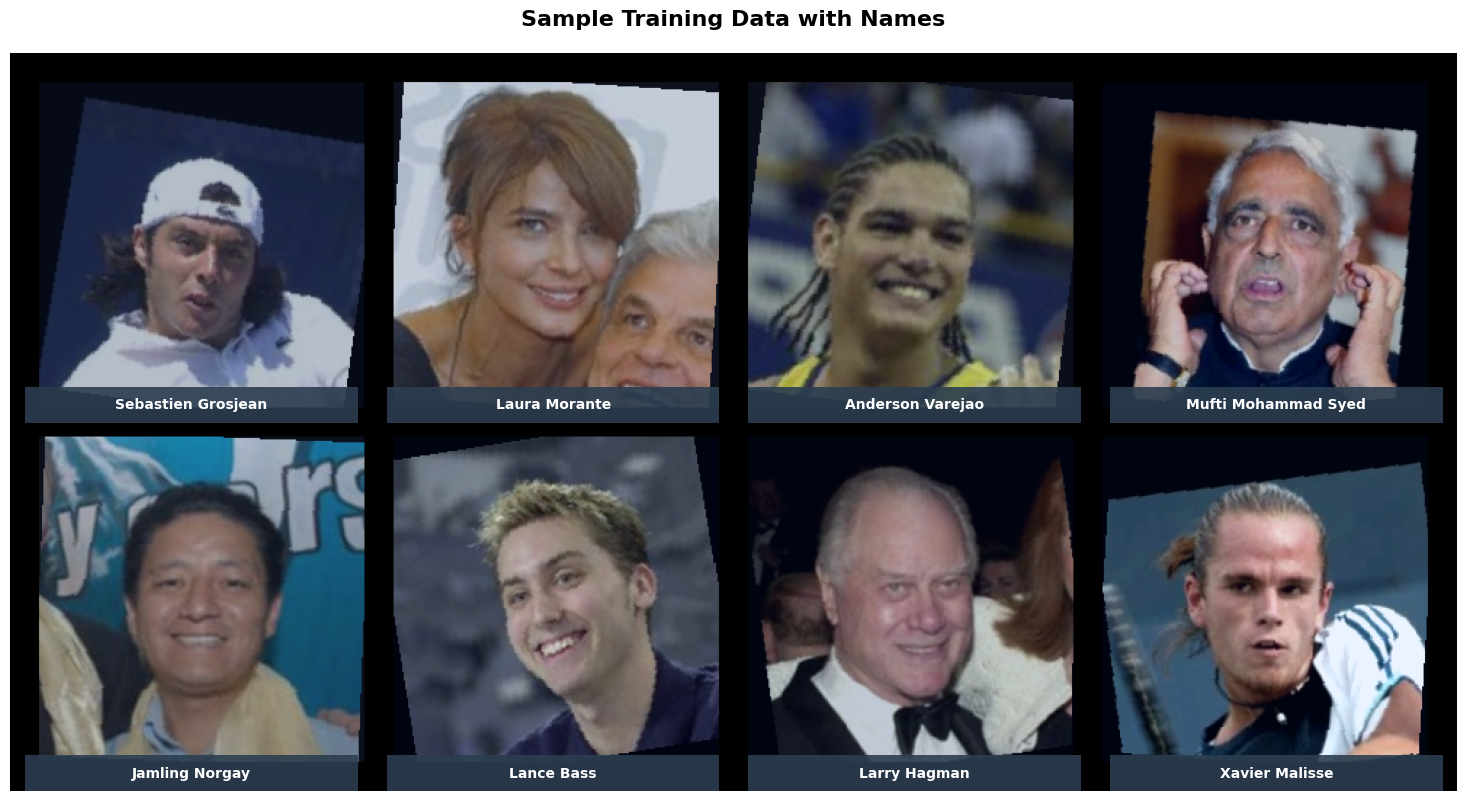

In [5]:

def show_sample_data(loader, dataset, num_images=8, rows=2):

    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # Calculate columns based on number of images and rows
    cols = num_images // rows
    
    # Create image grid with increased padding
    img_grid = make_grid(images[:num_images], nrow=cols, normalize=True, padding=20)
    
    # Create figure
    plt.figure(figsize=(15, 8))
    
    # Create the main axis for images
    ax = plt.gca()
    ax.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
    ax.axis('off')
    
    # Create reverse mapping of idx to class name
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    
    # Calculate grid dimensions
    grid_width = img_grid.size(2) / cols
    grid_height = img_grid.size(1) / rows
    
    # Style configurations
    label_font_size = 10
    background_color = '#2C3E50'  # Dark blue background for labels
    text_color = 'white'
    label_height = 25
    
    for i, label in enumerate(labels[:num_images]):
        person_name = idx_to_class[label.item()].replace('_', ' ') 
        
        # Calculate positions
        col = i % cols
        row = i // cols
        
        # Calculate center positions for the label
        x_center = col * grid_width + grid_width/2
        y_position = (row + 1) * grid_height - label_height/2
        
        # Add background rectangle for the label
        rect = Rectangle((col * grid_width + 10, y_position - label_height/2),
                        grid_width - 20, label_height,
                        facecolor=background_color,
                        alpha=0.9,
                        edgecolor='none',
                        zorder=2)
        ax.add_patch(rect)
        
        # Add text
        ax.text(x_center, y_position,
                person_name,
                color=text_color,
                fontsize=label_font_size,
                fontweight='bold',
                ha='center',
                va='center',
                zorder=3)
    
    # Add title with proper styling
    plt.title("Sample Training Data with Names",
              pad=20,
              fontsize=16,
              fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Show the sample data with improved formatting
show_sample_data(train_loader, lfw_dataset)

In [6]:
# Get the number of classes
num_classes = len(lfw_dataset.class_to_idx)

# Create the model with fine-tuning
def create_model(num_classes):
    model = models.resnet50(pretrained=True)
    
    # Unfreeze some layers for fine-tuning
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze the last few layers for fine-tuning
    for param in model.layer4.parameters():
        param.requires_grad = True
    
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.5),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.2),
        nn.Linear(256, num_classes)
    )
    return model

model = create_model(num_classes).to(device)

# Define loss function and optimizer with learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training and evaluation functions with learning rate scheduling
def train_model(model, criterion, optimizer, scheduler, num_epochs=200):
    best_acc = 0.0
    patience = 20
    counter = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []  # Initialize lists to store metrics

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        train_losses.append(epoch_loss)  # Store training loss
        train_accs.append(epoch_acc.item())  # Store training accuracy

        val_loss, val_acc = evaluate_model(model)
        val_losses.append(val_loss)  # Store validation loss
        val_accs.append(val_acc)  # Store validation accuracy
        
        scheduler.step()

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break

    return model, train_losses, val_losses, train_accs, val_accs  # Return additional metrics

def evaluate_model(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects.double() / len(val_dataset)

    return epoch_loss, epoch_acc.item()

# Train the model with fine-tuning and learning rate scheduling
model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, scheduler)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


Epoch 1/200
Train Loss: 8.4912 Acc: 0.0350
Val Loss: 7.9528 Acc: 0.0857
Epoch 2/200
Train Loss: 7.8833 Acc: 0.0895
Val Loss: 7.3966 Acc: 0.1195
Epoch 3/200
Train Loss: 7.4353 Acc: 0.1132
Val Loss: 7.0302 Acc: 0.1349
Epoch 4/200
Train Loss: 7.0749 Acc: 0.1316
Val Loss: 6.7192 Acc: 0.1560
Epoch 5/200
Train Loss: 6.7564 Acc: 0.1524
Val Loss: 6.3679 Acc: 0.1764
Epoch 6/200
Train Loss: 6.4697 Acc: 0.1728
Val Loss: 6.1083 Acc: 0.1933
Epoch 7/200
Train Loss: 6.2234 Acc: 0.1874
Val Loss: 5.9336 Acc: 0.2125
Epoch 8/200
Train Loss: 5.9520 Acc: 0.2053
Val Loss: 5.8445 Acc: 0.2229
Epoch 9/200
Train Loss: 5.8870 Acc: 0.2129
Val Loss: 5.7997 Acc: 0.2241
Epoch 10/200
Train Loss: 5.8348 Acc: 0.2194
Val Loss: 5.7461 Acc: 0.2260
Epoch 11/200
Train Loss: 5.8015 Acc: 0.2175
Val Loss: 5.7354 Acc: 0.2294
Epoch 12/200
Train Loss: 5.7700 Acc: 0.2238
Val Loss: 5.6930 Acc: 0.2325
Epoch 13/200
Train Loss: 5.7311 Acc: 0.2253
Val Loss: 5.6820 Acc: 0.2360
Epoch 14/200
Train Loss: 5.6943 Acc: 0.2324
Val Loss: 5.6401

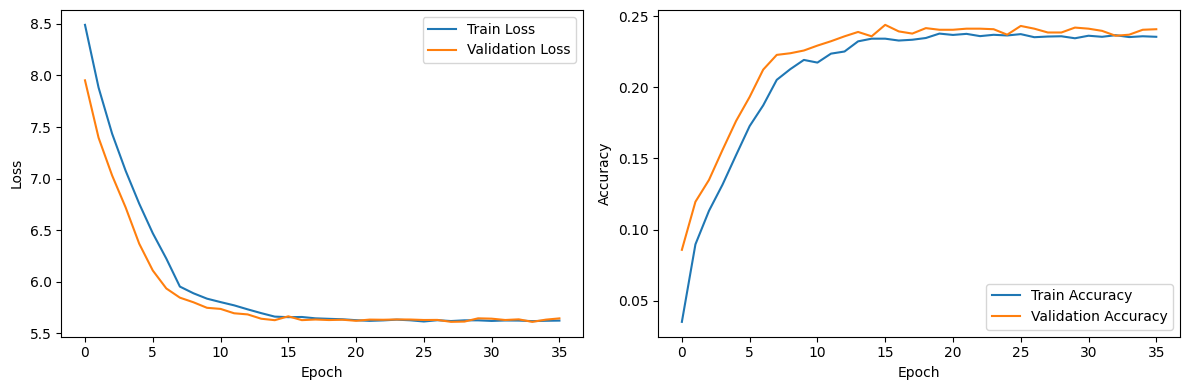

In [7]:
# Visualization function
def plot_training_progress(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training progress
plot_training_progress(train_losses, val_losses, train_accs, val_accs)